### This notebook has refered the following codebook
### Credit to 
https://www.kaggle.com/code/suniliitb96/tutorial-keras-transfer-learning-with-resnet50<br>
https://www.kaggle.com/code/gpreda/cats-or-dogs-using-cnn-with-transfer-learning <br>
https://www.kaggle.com/code/jeffd23/catdognet-keras-convnet-starter/notebook<br>
https://www.kaggle.com/code/rajmehra03/a-comprehensive-guide-to-transfer-learning<br>
https://www.kaggle.com/code/stephanedc/tutorial-cnn-partie-3-mod-le-vgg16    <br>

In [1]:
%matplotlib inline
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import os, cv2, random       # working with, mainly resizing, images
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from tqdm import tqdm  #Used for the purpose of showing iterations getting loaded in bar form
from random import shuffle, sample
from shutil import copyfile
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
# Data importation and preprocessing
common_path = '/Users/wzy/Desktop/HW4'
train_d = '/Users/wzy/Desktop/HW4/train/'
test_d = '/Users/wzy/Desktop/HW4/test/'
resize = 224
rgb = 3
num_class = 2

train_img_list =  os.listdir(train_d)
test_img_list = os.listdir(test_d)

In [11]:
# print(train_img_list[:10])
# print(test_img_list[:10])

['dog.8011.jpg', 'cat.5077.jpg', 'dog.7322.jpg', 'cat.2718.jpg', 'cat.10151.jpg', 'cat.3406.jpg', 'dog.1753.jpg', 'cat.4369.jpg', 'cat.7660.jpg', 'dog.5535.jpg']
['9733.jpg', '63.jpg', '6400.jpg', '823.jpg', '4217.jpg', '3578.jpg', '10321.jpg', '2666.jpg', '5109.jpg', '11981.jpg']


In [15]:
# for i in train_img_list[:10]:
#     pet = i.split('.')[-3]
#     print(pet)

dog
cat
dog
cat
cat
cat
dog
cat
cat
dog


In [3]:
# extract the first 3 letters from the image names, which gives the label of the image, and then use one-hot-encoding
# to represent the label
def label_ohe(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]
# Process the training and testing data
def process_data(img_list, data_d, isTrain=True):
    data_df = []
    for img in tqdm(img_list):
        path = os.path.join(data_d,img)         #Assigning path to images by concatenating directory and images
        if(isTrain):
            pet_label = label_ohe(img)            #Calling label_img to assign labels to image present in training directory
        else:
            pet_label = img.split('.')[0]
            
        img = cv2.imread(path, cv2.IMREAD_COLOR) #default value for flag is cv2.IMREAD_COLOR. It can also be cv2.IMREAD_GRAYSCALE
        img = cv2.resize(img, (224, 224)) 
        data_df.append([np.array(img),np.array(pet_label)])          #append image and labels as numpy array in data_df list
    shuffle(data_df)
    return data_df

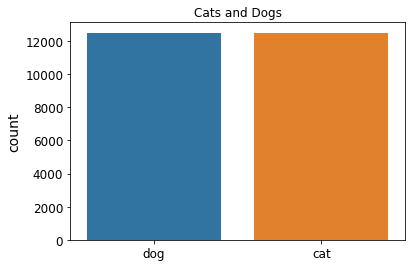

In [103]:
# inspect the train data to check the cat/dog distribution
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    sns.countplot(labels)
    plt.title('Cats and Dogs')
    
plot_image_list_count(train_img_list)

In [4]:
train = process_data(train_img_list, train_d)
# train is a list here

100%|████████████████████████████████████| 25000/25000 [01:42<00:00, 243.85it/s]


In [28]:
# for i, data in enumerate(train[:5]):
#     print(data[1])

[1 0]
[0 1]
[1 0]
[0 1]
[1 0]


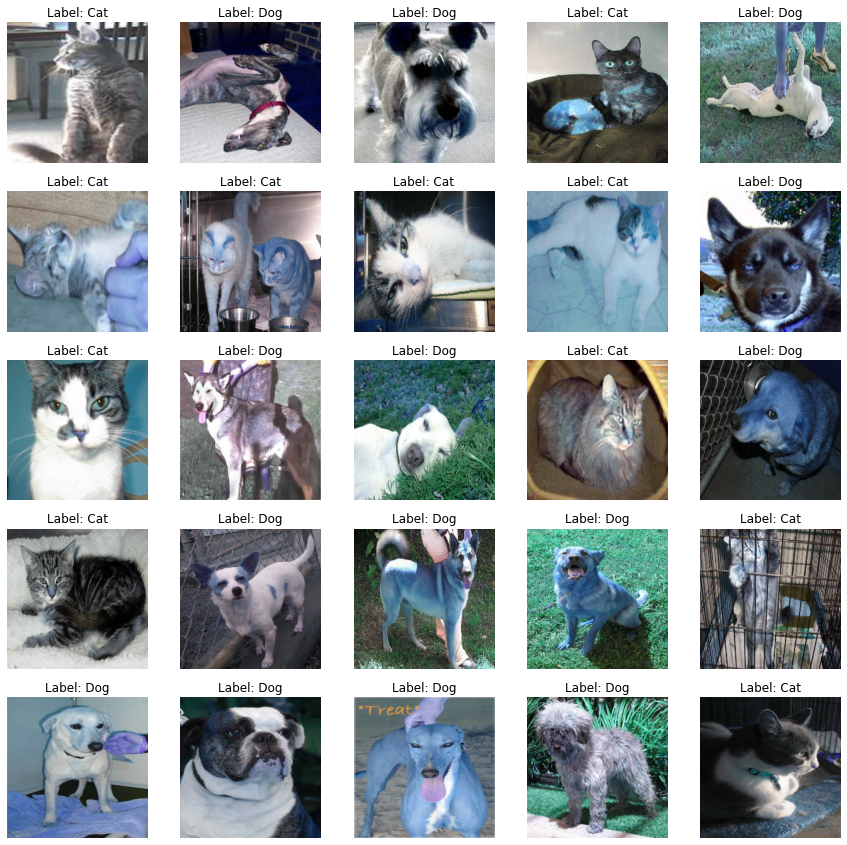

In [105]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(train)

In [5]:
test = process_data(test_img_list, test_d, False)
# test_path

100%|████████████████████████████████████| 12500/12500 [00:57<00:00, 217.12it/s]


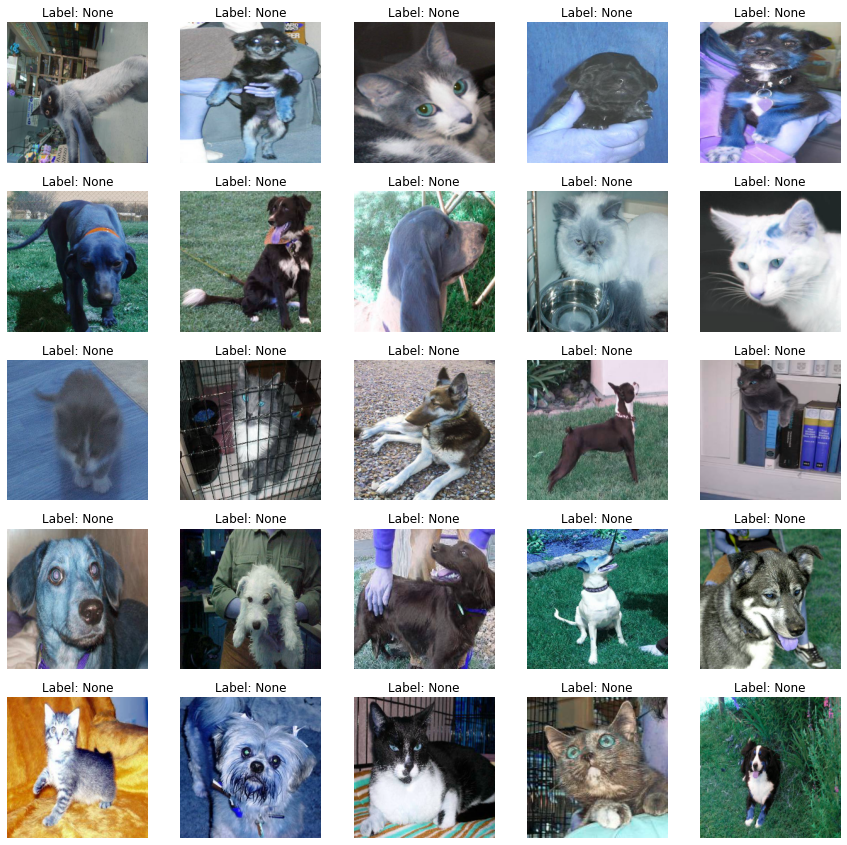

In [107]:
show_images(test,True)

In [6]:
# Sample the data to speed up first
# Train the model using sample data and test using all the data
train_s = sample(train, 1000)

In [7]:
X = np.array([i[0] for i in train_s]).reshape(-1,resize,resize,rgb)
y = np.array([i[1] for i in train_s])

In [21]:
print(len(X))
print(len(y))
print(X.shape)
print(y.shape)

1000
1000
(1000, 224, 224, 3)
(1000, 2)


In [8]:
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(resize,resize,rgb), pooling='avg')

2022-03-31 09:40:28.321278: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [9]:
for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(Dense(256, activation='relu'))
model.add(Dense(num_class, activation='sigmoid'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = False

In [10]:
# Define earlystopping and reduce based on val_loss since the final score is probably dependent on loss
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.00001, verbose=1)

In [13]:
base_model.trainable=False

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 24,112,770
Trainable params: 525,058
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2018)

In [13]:
RESNET50_POOLING_AVERAGE = 'avg'
OBJECTIVE_FUNCTION = 'binary_crossentropy'

LOSS_METRICS = ['accuracy']
BATCH_SIZE = 64
# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
EPOCH_TIME = 50
EARLY_STOP_PATIENCE = 3
# # In case of OF
# Dropout
# regularization
# SpatialDropout 
# Batch normalization has been covered by preprocess_input and it helps in faster convergence `done`

# shuffle your training data `done`
# use SGD+momentum since it tends to reach better optima.

In [14]:
# Let's the train the model now
train_model = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCH_TIME,
                        verbose=1,
                        validation_data=(X_valid, y_valid),
                        callbacks = [es, rlr])

Epoch 1/50
13/13 [==============================] - 65s 5s/step - loss: 0.2420 - accuracy: 0.9425 - val_loss: 0.0751 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 64s 5s/step - loss: 0.0281 - accuracy: 0.9937 - val_loss: 0.0489 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 57s 4s/step - loss: 0.0129 - accuracy: 0.9975 - val_loss: 0.0421 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 58s 4s/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.0385 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 65s 5s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0343 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 66s 5s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0341 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 7/50
13/13 [==============================] - 60s 5s/step - loss: 0.0013 - a

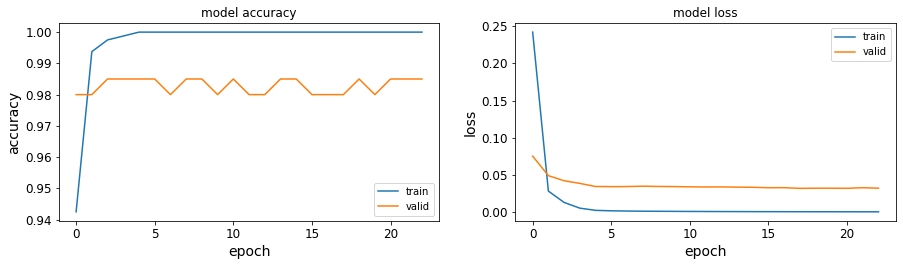

In [15]:
# epoch  = 64 & pooling = 'avg‘
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(train_model.history['accuracy'])  
plt.plot(train_model.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(train_model.history['loss'])  
plt.plot(train_model.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 


In [16]:
# The numeric validation accuracy and loss is:
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=0)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

Validation loss: 0.03202435374259949
Validation accuracy: 0.9850000143051147


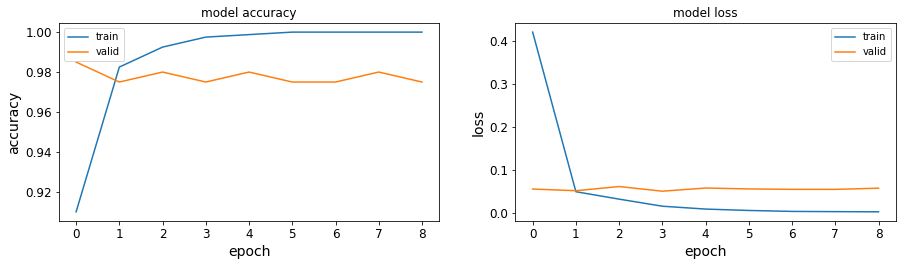

In [150]:
# Plot the train and validation accuracy on the same plot
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(train_model.history['accuracy'])  
plt.plot(train_model.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(train_model.history['loss'])  
plt.plot(train_model.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

In [151]:
# The numeric validation accuracy and loss is:
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=0)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

Validation loss: 0.05662068724632263
Validation accuracy: 0.9750000238418579


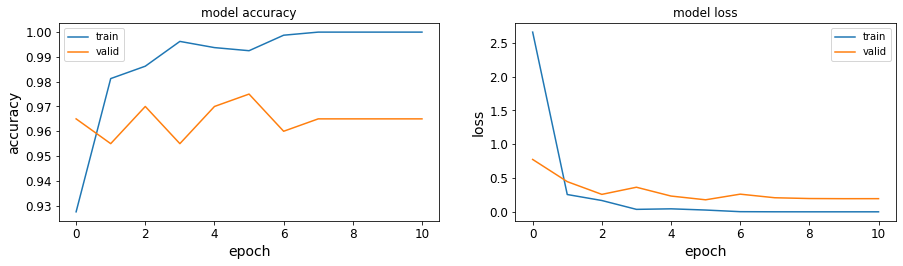

In [32]:
# Plot the train and validation accuracy on the same plot
# epoch  = 64 & pooling = 'max‘
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(train_model.history['accuracy'])  
plt.plot(train_model.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(train_model.history['loss'])  
plt.plot(train_model.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

In [17]:
pred_label_list = []
pred_list = []
for i in tqdm(test):
    img_dataset = i[0]
    img_index = i[1]
    data = img_dataset.reshape(-1,resize,resize,3)
    predicted = model.predict([data])[0]
    pred_list.append(img_index)
    pred_label_list.append(predicted[1])

100%|█████████████████████████████████████| 12500/12500 [27:08<00:00,  7.67it/s]


In [18]:
print(len(pred_list))
print(len(pred_label_list))

12500
12500


In [19]:
submission = pd.DataFrame({'id':pred_list , 'label':pred_label_list})
submission.head()
submission.to_csv("submission.csv", index=False)

## Reflections after doing this competition
After trying different combination of epoch and batch size, I found that by decreasing the batch_size could decrease
validation loss and increase the validation accuracy.<br>
Other findings include: <br>
Set'optimizer' = 'adam' increase the speed of converge, and also, by default, the learning rate for 'adam' = 0.001<br>
Define checkpoint will prevent models from overfitting and stop it before it makes no sense to train further.<br>
Personalize checkpoint based on the metrics that you emphasize, eg.'val_loss'/'val_accuracy'<br>
If you declare Metrics = 'Accuracy' that spelled out in full, when you plot, remember to use the full spelling in case of error.<br>
Use 'imagenet' as weight to build models<br>
If use transfer learning, remember to set include_top=False to only modify the last layer.<br>
use pooling = 'avg' instead of pooling = 'max' to get better outcome<br>
Since the model is complex and the dataset is pretty large, if using the personal computer GPU to train the whole 
dataset, it would take 'infinite time' to train that, thus, a quicker way to do this is to sample data from our
training dataset and train our model based on sampled data, however, this definitely will decrease the accuracy of the
model<br>
